# DC2 Object Catalog Run2.1i GCR tutorial -- Part I: GCR access

Owners: **Francois Lanusse [@EiffL](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@EiffL), Javier Sanchez [@fjaviersanchez](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@fjaviersanchez)**  
Last Verifed to Run: **2020-01-22** (by @reneehlozek)

This notebook will illustrate the basics of accessing the DPDD-like object catalog, which contains the detected objects at the coadd level, through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) as well as how to select useful samples of stars/galaxies from the DM outputs.

__Learning objectives__:

After going through this notebook, you should be able to:
  1. Load and efficiently access a DC2 object catalog with the GCR
  2. Understand and have references for the catalog schema
  3. Apply cuts to the catalog using GCR functionalities
  4. Have an example of quality cuts and simple star/galaxy separation cut
  5. Load the HSC Public Data Release catalog in the XMM field [Advanced]

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

__Other notes__: 
   * If you restart your kernel, or if it automatically restarts for some reason, all imports and variables will become undefined so, you probably will have to re-run everything.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Accessing the object catalog with the GCR

The [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) package is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration.  
In this section, we illustrate how to use this tool to access the object catalogs from DC2 Run2.1i.

In [12]:
import GCRCatalogs
sorted(GCRCatalogs.get_available_catalogs(False)) 
# Load the object catalog
catalog = GCRCatalogs.load_catalog('dc2_object_run2.1i_dr4')

A significant numbers of catalogs besides the DC2 object catalogs are already available, use `sorted(GCRCatalogs.get_available_catalogs(False))` to see a full list and visit the [DC2 Data Product](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview) page to see all the DC2 related catalogs.

### DC2 object catalog Schema


To see the quantities available in the catalog, you can use the following:

In [14]:
#sorted(catalog.list_all_quantities())

The meaning of these fields is documented in the [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) file of the `LSSTDESC/gcr-catalogs` repository.  
As explained in that link, the values exposed here are not the native quantities produced by the Data Management stack, but instead this schema strives to follow the standard nomenclature of the LSST Data Products Definition Document [DPDD](http://ls.st/dpdd).

The DPDD is an effort made by the LSST project to standardize the format of the official Data Release Products (DRP). While the native outputs of the DM stack are succeptible to change, the DPDD will be more stable. An early adoption of these conventions by the DESC will save time and energy down the road.

This being said, not all use-cases and relevant quantities are covered by these conventions yet, so the GCR preserves access to the underlying native DM stack fieds, all 2046 of which can be listed using:  

In [16]:
#sorted(catalog.list_all_native_quantities())

We can see that the catalog includes:

* Positions
* Fluxes and magnitudes (PSF and [CModel](https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel))
* Shapes (using [GalSim's HSM](http://galsim-developers.github.io/GalSim/namespacegalsim_1_1hsm.html))
* Quality flags: e.g, does the source have any interpolated pixels? Has any of the measurement algorithms returned an error?
* Other useful quantities: `blendedness`, measure of how flux is affected by neighbors: (1 - flux.child/flux.parent) (see 4.9.11 of [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B)); `extendedness`, classifies sources in extended and psf-like.

### Accessing the data

While Run2.1i is still of manageable size, full DC2 will be much larger, accessing the whole data can be challenging. In order to access the data efficiently, it is important to understand how it is physically stored and how to access it, one piece at the time. 


The coadds produced by the DM stack are structured in terms of large `tracts` and smaller `patches`, illustrated here for DC2:
<img src="assets/dc2_skymap.png">
Here the tracts have large blue numbers, and the patches are denoted with an `(x,y)` format. For DC2, each tract has 8x8 patches.

You can learn more about how to make such a plot of the tract and patches [here](dm_butler_skymap.ipynb)

The **GCR object catalog preserves this structure of the data** so that any particular quantity can be accessed on a tract/patch bases. The tracts available in the catalog can be listed using the following command:

In [19]:
# Query all available tracts and patches, only displays the first 5
catalog.available_tracts[:5]
#catalog.available_tracts_and_patches[:5]

[2723, 2724, 2725, 2726, 2727]

The DM stack includes functionality to get the tract and patch number corresponding to a certain position `(RA,DEC)`. However, it is out of the scope of this tutorial.

GCR provides the following `native_filters` mechanism, which you can use to speed up data access if you only need a certain chunks of the dataset.
For the object catalog, the chunks are broken into `tract` and `patch`, and hence those are the `native_filters` you can use:

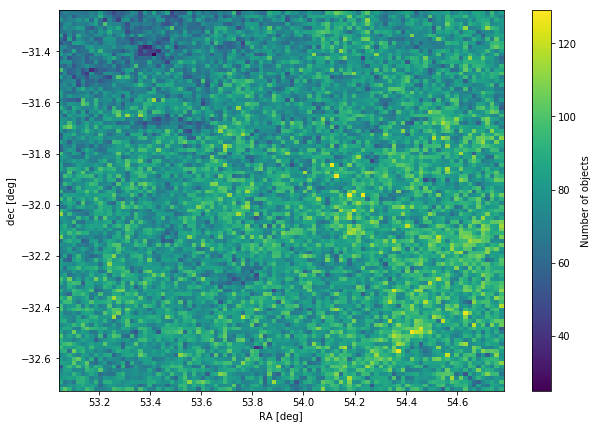

In [20]:
# Retrieve the ra,dec coordinates of all sources within tract number 4430
data = catalog.get_quantities(['ra', 'dec'], native_filters=['tract == 4430'])

# Plot a 2d histogram of sources
plt.figure(figsize=(10,7))
plt.hist2d(data['ra'], data['dec'],100); plt.gca().set_aspect('equal'); plt.colorbar(label='Number of objects')
plt.xlabel('RA [deg]');
plt.ylabel('dec [deg]');

`native_filters` can be used to filter a catalog by some specific quantities that are related to its underlying data format
(use `catalog._native_filter_quantities` to see them). You have more information [here](https://yymao.github.io/generic-catalog-reader/)

The data returned by the GCR is structured as a native Python dictionary:

In [21]:
data

{'dec': array([-32.72700681, -32.7271185 , -32.72675624, ..., -31.31877823,
        -31.2806463 , -31.28090886]),
 'ra': array([54.74332193, 54.68906928, 54.68413492, ..., 53.23732964,
        53.09931794, 53.09870228])}

But it can also easily be converted into a [Pandas DataFrame](https://pandas.pydata.org), if you are so inclined ;-)

In [22]:
import pandas
pdata = pandas.DataFrame(data)
pdata

,dec,ra
0,-32.727007,54.743322
1,-32.727119,54.689069
2,-32.726756,54.684135
3,-32.726887,54.723945
4,-32.726765,54.711294
5,-32.727087,54.702669
6,-32.726990,54.672518
7,-32.726755,54.721163
8,-32.727022,54.693207
9,-32.727257,54.631126


As a simple test, you can show the advantage of loading one tract at a time compared to the entire catalog:

In [23]:
%time data = catalog.get_quantities(['ra', 'dec'], native_filters=['tract == 4431'])

CPU times: user 52.5 ms, sys: 21.1 ms, total: 73.6 ms
Wall time: 168 ms


In [24]:
%time data = catalog.get_quantities(['ra', 'dec']) #This cell takes a bit to execute so, if you are in a hurry you can skip this

CPU times: user 8.7 s, sys: 3.01 s, total: 11.7 s
Wall time: 28.7 s


In order to make accessing chunks of data convenient to the user, the `catalog.get_quantities` also provides the option to [return an iterator](https://yymao.github.io/generic-catalog-reader/#GCR.BaseGenericCatalog.get_quantities). This allows you to only read and work on one piece of data at a time while looping through the entire catalog. Remember that catalogs can be very large and might not fit in memory if you try to load the entire catalog at once. In the DC2 object catalog, as we follow the DM structure of data, the catalog will iterate over `tract` and `patch` when using `return_iterator`. 

You can find more general information about iterators [here](https://stackoverflow.com/questions/3294889/iterating-over-dictionaries-using-for-loops).

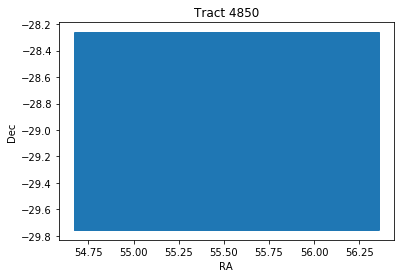

In [25]:
# Loop through all the patches of a given tract using an iterator
for d in catalog.get_quantities(['ra', 'dec'],
                                native_filters=['tract == 4850'],
                                return_iterator=True):
    # Here we only handle a small amount of data at a time
    plt.scatter(d['ra'], d['dec'], s=2);
    
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Tract 4850');

### Applying filters and cuts

In order to avoid returning unecessary data, the GCR has a functionality to filter out entries as it reads the files. Note that this is different from the `native_filters` discussed above, which avoids reading part of the data altogether.

Defining these filters requires the `GCRQuery` module of the GCR package and can then be applied during the call to `get_quantities`:

In [26]:
from GCR import GCRQuery

# Simple cut to remove unreliable detections
# More cuts can be added, as a logical AND, by appending GCRQuery objects to this list
simple_cuts = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
]

# Loads the data after cut
data_cut = catalog.get_quantities(['ra', 'dec'], 
                              filters = simple_cuts, 
                              native_filters=['tract == 4849'])

# Loads data without cuts
data_full = catalog.get_quantities(['ra', 'dec'], 
                              native_filters=['tract == 4849'])

In [27]:
print(len(data_cut['ra']),len(data_full['ra']))

428747 431309


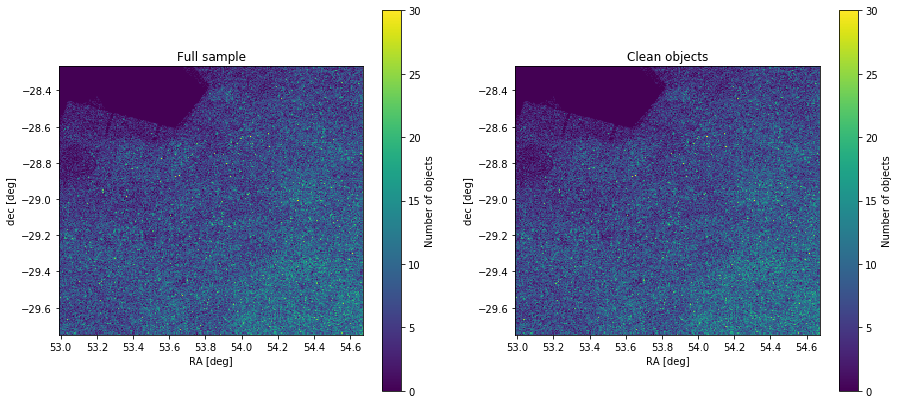

In [28]:
# Plot a 2d histogram of sources
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist2d(data_full['ra'], data_full['dec'],256); plt.gca().set_aspect('equal'); 
plt.xlabel('RA [deg]');
plt.ylabel('dec [deg]');
plt.title('Full sample')
plt.colorbar(label='Number of objects')

plt.subplot(122)
plt.hist2d(data_cut['ra'], data_cut['dec'],256); plt.gca().set_aspect('equal');
plt.xlabel('RA [deg]');
plt.ylabel('dec [deg]');
plt.title('Clean objects');
plt.colorbar(label='Number of objects');

Admittedly, this plot is a little underwhelming, these quality cuts only remove a very small number of objects. This is due in part to the fact that Run 2.1i ran from imSim outputs with essentially perfect Instrument Signature Removal (ISR). Also, Run 2.1i coadds only have a limited number of exposures, but defects will add up as the coadds get deeper.

To get a sense of the impact of these quality flags on real data, we can load with the GCR a tract of the HSC PDR1 data ([Aihara et al (2018)](http://adsabs.harvard.edu/abs/2018PASJ...70S...8A)) which is made available on cori. Note that this HSC catalog follows the same schema as Run 2.1i. This tract is part of the XMM subfield of HSC (find out more about the HSC data release [here](https://hsc-release.mtk.nao.ac.jp/doc/) and [here](http://adsabs.harvard.edu/abs/2018PASJ...70S...8A)).

Let's load this catalog, and apply the same cuts:

In [29]:
cat_hsc = GCRCatalogs.load_catalog('hsc-pdr1-xmm')

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/GCRCatalogs/dc2_object.py:280: UserWarning: Falling back to reading all datafiles for column names
  warnings.warn('Falling back to reading all datafiles for column names')


In [30]:
# Loads the data after cut
data_cut = cat_hsc.get_quantities(['ra', 'dec'], 
                              filters = simple_cuts)

# Loads data without cuts
data_full = cat_hsc.get_quantities(['ra', 'dec'])

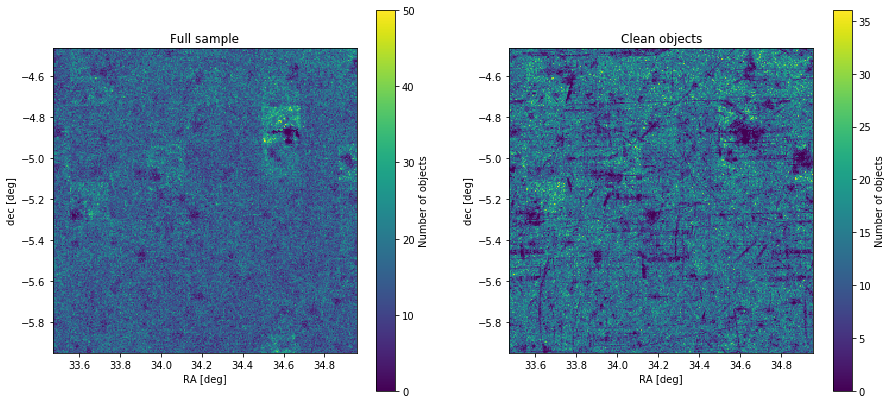

In [31]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist2d(data_full['ra'], data_full['dec'],256); plt.gca().set_aspect('equal'); 
plt.xlabel('RA [deg]');
plt.ylabel('dec [deg]');
plt.colorbar(label='Number of objects')
plt.title('Full sample')

plt.subplot(122)
plt.hist2d(data_cut['ra'], data_cut['dec'],256); plt.gca().set_aspect('equal');
plt.xlabel('RA [deg]');
plt.ylabel('dec [deg]');
plt.colorbar(label='Number of objects')
plt.title('Clean objects');

This is a more dramatic plot, and illustrates the importance of selecting clean samples of objets.

## Example of filtering: Star/galaxy separation

For now, we have `extendedness == base_ClassificationExtendedness_value` as a tool for star/galaxy classification. An object is considered extended if the the difference between the `PSF` magnitude and the [`CModel` magnitude](https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel) is beyond certain threshold (0.0164). To know more about this see [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B) section 4.9.10

In [32]:
star_cuts = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('extendedness==0'),
    GCRQuery((np.isfinite, 'mag_g_cModel')),
    GCRQuery((np.isfinite, 'mag_r_cModel')),
    GCRQuery((np.isfinite, 'mag_i_cModel')),
]

quantities = ['mag_g_cModel', 'mag_r_cModel', 'mag_i_cModel']

d = catalog.get_quantities(quantities, 
                           filters=star_cuts, 
                           native_filters=['tract == 4849'])

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


__Note__: The cell above will output some runtime warnings related to objects that have negative or zero measured fluxes but we can safely ignore the warning since those objects will not appear in our 2D histogram.

So now, we are selected what we think are stars. Let's take a look at the colors of these objects

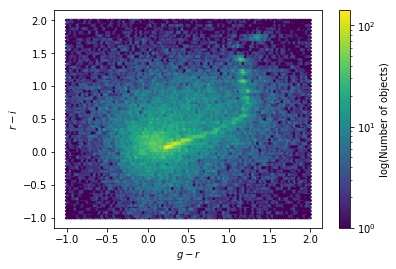

In [33]:
plt.hexbin(d['mag_g_cModel']-d['mag_r_cModel'],
           d['mag_r_cModel']-d['mag_i_cModel'], 
           bins='log', extent=[-1,2,-1,2]);
plt.xlabel('$g-r$')
plt.ylabel('$r-i$')
plt.colorbar(label='log(Number of objects)')

Q: What else can you do to improve the star selection?

__If you want to see more go to [Part II](object_gcr_2_lensing_cuts.ipynb)__